In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
#Size of our input images
SIZE = 128

In [3]:
import os 
os.chdir(r"C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\uninfected1")
uninfected_path = os.getcwd()
os.chdir(r"C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\parasitized1")
parasitized_path = os.getcwd()
os.chdir(r"C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\uninfected_test1")
uninfected_test_path = os.getcwd()

os.chdir(r"c:\Users\Alex\Documents\TFM_project\BottlesAnomalies_TFM\Autoencoders")


# Setting the training and testing datasets 

In [4]:
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    uninfected_path,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 13704 images belonging to 1 classes.


In [5]:
validation_generator = datagen.flow_from_directory(
    uninfected_test_path,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 75 images belonging to 1 classes.


In [6]:
anomaly_generator = datagen.flow_from_directory(
    parasitized_path,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 13779 images belonging to 1 classes.


# Configuring the Autoencoder netwrok

In [7]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [8]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/200
7/7 [==============================] - 21s 3s/step - loss: 0.0862 - mse: 0.0862 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 2/200
7/7 [==============================] - 19s 3s/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 3/200
7/7 [==============================] - 18s 3s/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 4/200
7/7 [==============================] - 19s 3s/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 5/200
7/7 [==============================] - 17s 2s/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6/200
7/7 [==============================] - 17s 2s/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 7/200
7/7 [==============================] - 17s 2s/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/200
7/7 [==============================] - 17s 2s/step - loss: 0.0115 - mse: 0.0115 - val

The above training stage took 51 m to complete.

In [11]:
model_version = 'firstCellModel'
model.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

INFO:tensorflow:Assets written to: ../../BottlesAnomalies_TFM/models/firstCellModel\assets


INFO:tensorflow:Assets written to: ../../BottlesAnomalies_TFM/models/firstCellModel\assets


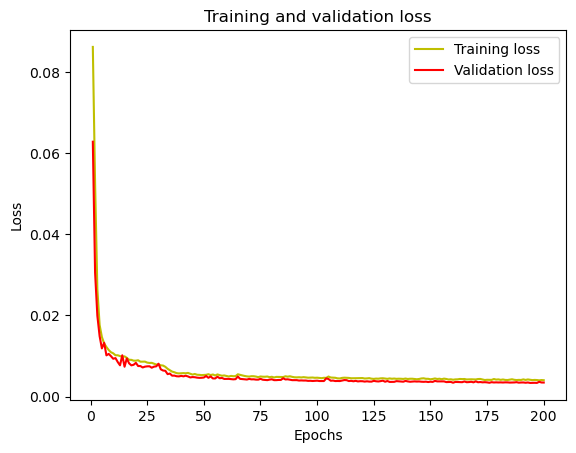

In [12]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get all batches generated by the datagen and pick a batch for prediction

In [13]:

#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  215


Predict on the first batch of images

In [14]:
predicted = model.predict(data_batch[0])  


2/2 [==============================] - 1s 215ms/step


In [15]:
predicted.shape

(64, 128, 128, 3)

The above is 64 length because it corresponds to the 64 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

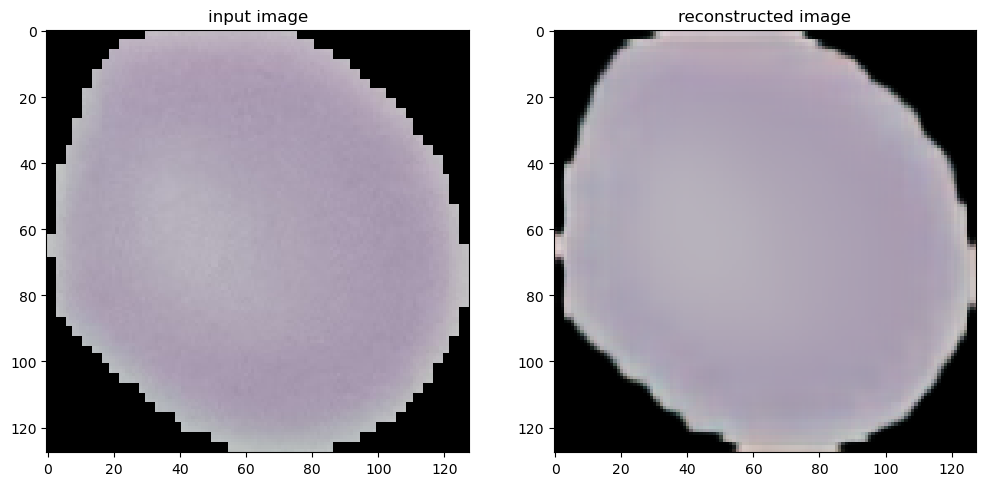

In [16]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

Let us examine the reconstruction error between our validation data (good/normal images) and the anomaly images

In [17]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\2207300971.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)


Recon. error for the validation (normal) data is:  [0.0034315248485654593, 0.0034315248485654593]


Here above we see a vector with two components which happen to be the same. This is because in the model, when we define the outputs, the loss function type and the metric are the same parameter, the mse (mean square error).

This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images (parasitized)

In [18]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\4089772597.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the anomaly data is:  [0.0046323128044605255, 0.0046323128044605255]


I think this error above should be higher. Anyway it is higher than the previous validation error.

# Working on the latent space of the model

This is a different approach of setting a threshold and detecting an anomaly. Instead of working directly with the error metric at the end of the model, it will be reached until the latent space of the model and in here a threshold value will be selected.

Let us extract (or build) the encoder network, with trained weights.

This is used to get the compressed output (latent space) of the input image. 

The compressed output is then used to calculate the KDE

In [19]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

NOtice that the new model: "encoder_model" is the same as "model" but without considering the decoder part of it, only the encoder part. 

It is now time to use this new model. This will generate a feature vector or also called by the video source of this notebook, the latent vector.

In [20]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\454703430.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [21]:
print(encoded_images.shape)

(13704, 16, 16, 16)


See that it is 13704 length because it corresponds to all the images that belong to the training dataset. Also the shape of the representation of the original images has been lowered to (16, 16, 16) as specified in the model structure. 
 

In [22]:
type(encoded_images)

numpy.ndarray

Now we will flatten the encoder output because KDE from sklearn takes 1D vectors as input

First we print the output shape of the encoder model

In [23]:
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
print(encoder_output_shape)

(None, 16, 16, 16)


Then we flatten the output of the enconded images in order for it to be (13704, 16 * 16 * 16)

In [24]:
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]
encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]


In [25]:
len(encoded_images_vector)

13704

In [26]:
encoded_images_vector[0].shape

(4096,)

Now, let's fit KDE to the image latent data


In [27]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images_vector" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images_vecotr". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

In [30]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

The function above, given a batch of images, does:
- Encodes a single image.
- Flattens the encoded image.
- Assign a density score of the flattened image using the previously computed "kde" variable.
- Computes a reconstruction error of the image. For this it uses the complete neural network model, the one that was created at the beginning. 
- Appends in two lists:
    - The reconstruction error.
    - The density score of the encoded model result.
- At the end, based on the density and reconstruction error, the funtion otuputs the mean and standard deviation of both metrics.

In [31]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]     # This is the uninfected images
anomaly_batch = anomaly_generator.next()[0] # This is the parasitized images

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)



1/1 [==============================] - 0s 37ms/step - loss: 0.0058 - mse: 0.0058


See that "uninfected_values" and "anomaly_values" have length of four and contain the average_density, stdev_density, average_recon_error, stdev_recon_error

In [35]:
print(uninfected_values)
print(anomaly_values)

(2818.7600142837364, 7.087883489561854e-12, 0.005494946303466956, 0.0009135791106844122)
(1635.4463236000852, 1167.4125009720128, 0.0068234895755137715, 0.0013553442590894956)


In [56]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
      

In [43]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob(r'C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\parasitized1\Parasitized\*')
uninfected_file_paths = glob.glob(r'C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\uninfected1\Uninfected\*')

1/1 [==============================] - 0s 30ms/step


C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\349380335.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0056 - mse: 0.0056
The image is an anomaly


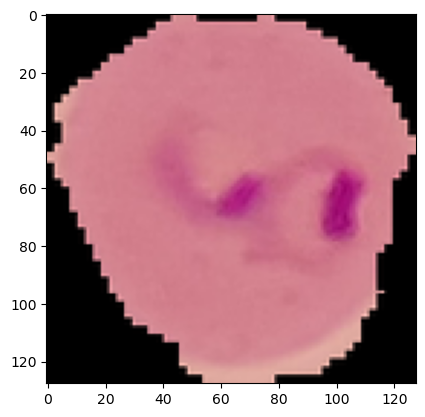

In [45]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

1/1 [==============================] - 0s 32ms/step


C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\3669532084.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0059 - mse: 0.0059
The image is NOT an anomaly


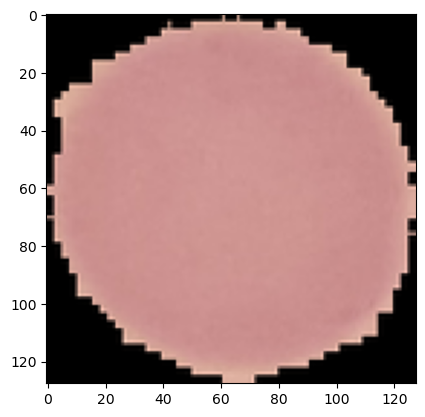

In [57]:
#Good/normal image verification
num=random.randint(0,len(uninfected_file_paths)-1)
check_anomaly(uninfected_file_paths[num])